In [28]:
import os
import pickle
#models_dir = '/media/fernando/DADOS/UNICAMP/PHD/models/2017-12-15'
models_dir = '../models'
dataset_dir = '../datasets'
logs_dir = '../logs'

In [29]:
# load auto tagged test set
test_set = pickle.load(open(os.path.join(dataset_dir, 'tweets_auto-tagged-emolex_svd_test.pkl'), "rb" ), encoding='latin1') 


In [30]:
import pandas as pd
dataframe_test = pd.read_csv(os.path.join(dataset_dir, 'tweets_auto-tagged-emolex_test.csv'), engine='c')

In [31]:
import numpy as np

print(dataframe_test.shape)

for dim in ["emolex_joy","emolex_sad","emolex_trust",\
                "emolex_disgust","emolex_anger","emolex_fear",\
                "emolex_anticipation","emolex_surprise",\
                "emolex_positive","emolex_negative"]:        
        test_set = np.c_[test_set, dataframe_test[dim]]


(55631, 24)


In [40]:
import csv

def read_results_csv(file_path, neutral_data=False):   
    rows = []
    with open(file_path) as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter=';')
        line_count = 0
        for row in csv_reader:            
            #row['Y'] = row['in_tree'][:row['in_tree'].find('\t')]
            if neutral_data:
                row['Y'] = 2
            else:
                row['Y'] = row['y']
            rows.append(row)
            
    return rows


In [41]:
# Loading one vs one results
results_csvs_auto_tagged = {}
results_csvs_stocks = {}
import pprint

for emo in [('JOY', 'SAD'), ('TRU', 'DIS'), ('ANG', 'FEA'), ('ANT', 'SUR')]:
#for emo in [('TRU', 'DIS'), ('ANG', 'FEA'), ('ANT', 'SUR')]:
    print("%s-vs-%s" % emo)
    
    results_csvs_auto_tagged["%s-vs-%s" % emo] = {}
        
    results_csvs_auto_tagged["%s-vs-%s" % emo]['emo-vs-emo'] = read_results_csv(os.path.join(logs_dir, \
                                                              'results_tweets_auto-tagged-emolex_test_svmlight_%s_vs_%s.csv' % emo))
        
    results_csvs_auto_tagged["%s-vs-%s" % emo]['emo-vs-emo-vs-neutral'] = results_csvs_auto_tagged["%s-vs-%s" % emo]['emo-vs-emo'] + \
                                                                read_results_csv(os.path.join(logs_dir, \
                                                              'results_tweets_auto-tagged-emolex_test_svmlight_%s_vs_%s_neutral.csv' % emo), True)


    
    #pprint.pprint(results_csvs_auto_tagged["%s-vs-%s" % emo][:10])
    
    print("%s-vs-%s" % emo)
    print(len(results_csvs_auto_tagged["%s-vs-%s" % emo]['emo-vs-emo']))
    print(len(results_csvs_auto_tagged["%s-vs-%s" % emo]['emo-vs-emo-vs-neutral']))
    
    results_csvs_stocks["%s-vs-%s" % emo] = {}
    results_csvs_stocks["%s-vs-%s" % emo]['emo-vs-emo'] = read_results_csv(os.path.join(logs_dir, \
                                                              'results_tweets_stocks_emolex_svmlight_%s_vs_%s.csv' % emo))    
    results_csvs_stocks["%s-vs-%s" % emo]['emo-vs-emo-vs-neutral'] = results_csvs_stocks["%s-vs-%s" % emo]['emo-vs-emo'] + \
                                                              read_results_csv(os.path.join(logs_dir, \
                                                              'results_tweets_stocks_emolex_svmlight_%s_vs_%s_neutral.csv' % emo), True)    
    
    
    print(len(results_csvs_stocks["%s-vs-%s" % emo]['emo-vs-emo']))
    print(len(results_csvs_stocks["%s-vs-%s" % emo]['emo-vs-emo-vs-neutral']))
    
    #pprint.pprint(results_csvs_stocks["%s-vs-%s" % emo][:10])
    
    #results_csvs_auto_tagged["%s-vs-%s" % emo] = pd.read_csv(os.path.join(logs_dir, \
    #                                                          'results_tweets_auto-tagged-emolex_test_svmlight_%s_vs_%s.csv' % emo),
    #                                                        sep=';', engine='python', quotechar='"', error_bad_lines=False)
    
    #results_csvs_auto_tagged["%s-vs-%s" % emo]['Y'] = results_csvs_auto_tagged["%s-vs-%s" % emo]['in_tree'][0:results_csvs_auto_tagged["%s-vs-%s" % emo]['in_tree'].find('\t')]
    
    #print(results_csvs_auto_tagged.head())
    
    #results_csvs_stocks["%s-vs-%s" % emo] = pd.read_csv(os.path.join(logs_dir, \
    #                                                          'results_tweets_stocks-emolex_svmlight_%s_vs_%s.csv' % emo),
    #                                                   sep=';', engine='python', quotechar='"', error_bad_lines=False)
    #results_csvs_stocks["%s-vs-%s" % emo]['Y'] = results_csvs_stocks["%s-vs-%s" % emo]['in_tree'][0:results_csvs_stocks["%s-vs-%s" % emo]['in_tree'].find('\t')]
    
    #print(results_csvs_stocks.head())
    
    
    

JOY-vs-SAD
JOY-vs-SAD
36540
46592
968
3307
TRU-vs-DIS
TRU-vs-DIS
2941
46659
1560
3088
ANG-vs-FEA
ANG-vs-FEA
6206
46653
488
3510
ANT-vs-SUR
ANT-vs-SUR
1279
46659
1152
2913


In [42]:
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

def svm_tree_classifier(clf_key, key_0, key_1, exp_name, corpus_name, alg_name, logs_path, dataset_path, best_pars=False):
    
    if corpus_name == 'free-domain':
        results_tk = results_csvs_auto_tagged
    elif corpus_name == 'stock-domain':
        results_tk = results_csvs_stocks
    else:
        results_tk = results_csvs_stocks_full_agreeement

    if exp_name == 'emo-vs-emo-vs-neutral':
        thresholds = pickle.load(open(os.path.join(models_dir, 'probs_train_neutral_tk.pkl'), 'rb'))
        print(thresholds[clf_key][key_0]['threshold'])
        print(thresholds[clf_key][key_1]['threshold'])
        
    Y_pred = []
    Y = []
    Y_prob = []
    i = 0
    for row in results_tk[clf_key][exp_name]:
        #try:
            #print(row)
        #    if not int(row['Y']) in [-1, 1]:
        #        print(row)
        #except:
        #    print(row)
        #    print(i)
        #i += 1
        
        if int(row['Y']) == -1:
            Y.append(0)
        elif int(row['Y']) == 1:
            Y.append(1)
        else:
            Y.append(2)
        #Y.append(0 if int(row['Y']) == -1 else 1 int(row['Y']) == 1 else 2)
        Y_prob.append([row['tk-1']])
        if exp_name == 'emo-vs-emo-vs-neutral':
            if row[alg_name] != None and \
               float(row[alg_name]) < thresholds[clf_key][key_0]['threshold'] and \
               float(row[alg_name]) > thresholds[clf_key][key_1]['threshold']:
                Y_pred.append(2)
            else:
                if row[alg_name] != None and float(row[alg_name]) <= 0.0:
                    Y_pred.append(0)
                else:
                    Y_pred.append(1)
        else:
            if row[alg_name] != None and float(row[alg_name]) <= 0.0:
                Y_pred.append(0)
            else:
                Y_pred.append(1)   
        
        
    print(Y_pred[:10])
    print(Y[:10])        
    
    Y_pred = np.array(Y_pred)
    Y = np.array(Y)
    
    # We need to scale Y_prob, since it holds the output from SVM TK
    scaler = MinMaxScaler()
    scaler.fit(Y_prob)
    Y_prob = scaler.transform(Y_prob)
    
    if exp_name != 'emo-vs-emo-vs-neutral':
        fpr, tpr, threshoulds = roc_curve(Y_pred, [prob[0] for prob in Y_prob])
        roc_auc = auc(fpr, tpr)
            
    f1 = f1_score(Y, Y_pred, average='macro')
    acc = accuracy_score(Y, Y_pred)
    
    if not exp_name in results.keys():
        results[exp_name] = {}
        
    if not corpus_name in results[exp_name].keys():
        results[exp_name][corpus_name] = {}
        
    if not alg_name in results[exp_name][corpus_name].keys():
        results[exp_name][corpus_name][alg_name] = {clf_key:{'f1':None, 'acc': None}}
        
    if not clf_key in results[exp_name][corpus_name][alg_name].keys():
        results[exp_name][corpus_name][alg_name][clf_key] = {'f1':None, 'acc': None}

        
    results[exp_name][corpus_name][alg_name][clf_key]['y'] = Y
    results[exp_name][corpus_name][alg_name][clf_key]['y_pred'] = Y_pred
        
    results[exp_name][corpus_name][alg_name][clf_key]['f1'] = f1
    results[exp_name][corpus_name][alg_name][clf_key]['acc'] = acc
    
    if exp_name != 'emo-vs-emo-vs-neutral':
        results[exp_name][corpus_name][alg_name][clf_key]['fpr'] = fpr
        results[exp_name][corpus_name][alg_name][clf_key]['tpr'] = tpr
        results[exp_name][corpus_name][alg_name][clf_key]['threshoulds'] = threshoulds
        results[exp_name][corpus_name][alg_name][clf_key]['roc_auc'] = roc_auc
        
    if exp_name == 'emo-vs-emo-vs-neutral':
        classes_names = [key_0, key_1, 'neutral']
    else:
        classes_names = [key_0, key_1]
            
    print(classification_report(Y, Y_pred, target_names=classes_names))
    #print(classification_report(Y, Y_pred))
        
    '''print("\t\tConfusion Matrix: ")
    conf_matrix = confusion_matrix(Y, Y_pred)
        
    print("Predicted as:\t%s\t%s\t%s" % (key_1, key_0, "neutral"))
    print("%s tweets:\t%d\t%d\t%d" % (key_1, conf_matrix[0][0], conf_matrix[0][1], conf_matrix[0][2]))
    print("%s tweets:\t%d\t%d\t%d" % (key_0, conf_matrix[1][0], conf_matrix[1][1], conf_matrix[1][2]))
    print("%s tweets:\t%d\t%d\t%d" % ("neutral", conf_matrix[2][0], conf_matrix[2][1], conf_matrix[2][2]))'''
        
    print('\n')

In [43]:
emotions = [('SAD', 'JOY'), ('DIS', 'TRU'), ('FEA', 'ANG'), ('SUR', 'ANT')]
#emotions = [('DIS', 'TRU'), ('FEA', 'ANG'), ('SUR', 'ANT')]
results = {}

logs_path = '../logs'
dataset_path = '../datasets'

for emo_pair in emotions:
    emo_pair_key = '%s-vs-%s' % (emo_pair[1], emo_pair[0])
    
    
    #tk_list = ['tk-mos', 'tk-st', 'tk-sst', 'tk-sst-bow', 'tk-pt']
    tk_list = ['tk-1']
        
    for alg_name in tk_list:
        print(emo_pair_key)
        print("%s, free-domain" % alg_name)
        svm_tree_classifier(emo_pair_key, emo_pair[1], emo_pair[0], "emo-vs-emo", 'free-domain', alg_name, logs_path, dataset_path)
        print("%s, stock-domain" % alg_name)
        svm_tree_classifier(emo_pair_key, emo_pair[1], emo_pair[0], "emo-vs-emo", 'stock-domain', alg_name, logs_path, dataset_path)
        #print("%s, stock-domain-full-agreement" % alg_name)
        #svm_tree_classifier(emo_pair_key, emo_pair[1], emo_pair[0], "emo-vs-emo", 'stock-domain-full-agreement', alg_name, logs_path, dataset_path)

        
for emo_pair in emotions:
    emo_pair_key = '%s-vs-%s' % (emo_pair[1], emo_pair[0])
       
    print("Testing using neutral class")
    for alg_name in tk_list:
        print(emo_pair_key)
        print("%s, free-domain" % alg_name)
        svm_tree_classifier(emo_pair_key, emo_pair[1], emo_pair[0], "emo-vs-emo-vs-neutral", 'free-domain', alg_name, logs_path, dataset_path)
        print("%s, stock-domain" % alg_name)
        svm_tree_classifier(emo_pair_key, emo_pair[1], emo_pair[0], "emo-vs-emo-vs-neutral", 'stock-domain', alg_name, logs_path, dataset_path)
        #print("%s, stock-domain-full-agreement" % alg_name)
        #svm_tree_classifier(emo_pair_key, emo_pair[1], emo_pair[0], "emo-vs-emo", 'stock-domain-full-agreement', alg_name, logs_path, dataset_path)

JOY-vs-SAD
tk-1, free-domain
[1, 0, 1, 1, 0, 1, 1, 1, 1, 0]
[1, 0, 1, 1, 0, 1, 1, 1, 1, 0]
              precision    recall  f1-score   support

         JOY       0.97      0.96      0.96     14373
         SAD       0.97      0.98      0.98     22167

   micro avg       0.97      0.97      0.97     36540
   macro avg       0.97      0.97      0.97     36540
weighted avg       0.97      0.97      0.97     36540



tk-1, stock-domain
[1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
[0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
              precision    recall  f1-score   support

         JOY       0.68      0.38      0.49       531
         SAD       0.51      0.79      0.62       437

   micro avg       0.56      0.56      0.56       968
   macro avg       0.60      0.58      0.55       968
weighted avg       0.60      0.56      0.55       968



TRU-vs-DIS
tk-1, free-domain
[1, 0, 0, 1, 1, 1, 1, 0, 1, 0]
[1, 0, 0, 1, 1, 1, 1, 0, 1, 0]
              precision    recall  f1-score   support

         TRU       0.97 

In [21]:

import matplotlib.pyplot as plt

#emotions = [('SAD', 'JOY'), ('DIS', 'TRU'), ('FEA', 'ANG'), ('SUR', 'ANT')]
emotions = [('DIS', 'TRU'), ('FEA', 'ANG'), ('SUR', 'ANT')]

def print_roc_curve(results, emo_pair, exp_name, corpus_name, alg_name):
    emo_pair_key = '%s-vs-%s' % (emo_pair[1], emo_pair[0])                                

    plt.figure()
    if exp_name == 'emo-vs-emo-vs-neutral':
        roc_auc = results[exp_name][corpus_name][alg_name][emo_pair_key]['roc_auc_neutral'][emo_pair[1]]
        
        plt.plot(results[exp_name][corpus_name][alg_name][emo_pair_key]['fpr_neutral'][emo_pair[1]], \
                 results[exp_name][corpus_name][alg_name][emo_pair_key]['tpr_neutral'][emo_pair[1]], \
                 color='b', lw=2, alpha=0.3,
                 label='ROC for %s-vs-Neutral (AUC = %0.2f)' % (emo_pair[1], \
                                                     roc_auc))
        
        roc_auc = results[exp_name][corpus_name][alg_name][emo_pair_key]['roc_auc_neutral'][emo_pair[0]]
        
        plt.plot(results[exp_name][corpus_name][alg_name][emo_pair_key]['fpr_neutral'][emo_pair[0]], \
                 results[exp_name][corpus_name][alg_name][emo_pair_key]['tpr_neutral'][emo_pair[0]], \
                 color='g', lw=2, alpha=0.3,
                 label='ROC for %s-vs-Neutral (AUC = %0.2f)' % (emo_pair[0], \
                                                     roc_auc))
    else:
        roc_auc = results[exp_name][corpus_name][alg_name][emo_pair_key]['roc_auc']
    
        plt.plot(results[exp_name][corpus_name][alg_name][emo_pair_key]['fpr'], \
                 results[exp_name][corpus_name][alg_name][emo_pair_key]['tpr'], \
                 color='b', lw=2, alpha=0.3,
                 label='ROC for %s (AUC = %0.2f)' % (emo_pair_key, \
                                                     roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)        

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for %s' % emo_pair_key)
    plt.legend(loc="lower right")

    #ax2 = plt.gca().twinx()
    #ax2.plot(results[exp_name][corpus_name][alg_name][emo_pair_key]['fpr'], 
    #         results[exp_name][corpus_name][alg_name][emo_pair_key]['thresholds'], 
    #         markeredgecolor='r',linestyle='dashed', color='g')
    #ax2.set_ylabel('Threshold',color='g')
    #ax2.set_ylim([clf[emo_pair_key][emo_pair[i]]['roc-thresholds'][-1],
    #              clf[emo_pair_key][emo_pair[i]]['roc-thresholds'][0]])
    #ax2.set_xlim([clf[emo_pair_key][emo_pair[i]]['roc-fpr'][0],
    #              clf[emo_pair_key][emo_pair[i]]['roc-fpr'][-1]])

    
    plt.savefig('visualization/roc-%s-%s-%s-svd-200-%s.png' % (emo_pair_key, exp_name, corpus_name, alg_name))
    plt.show()

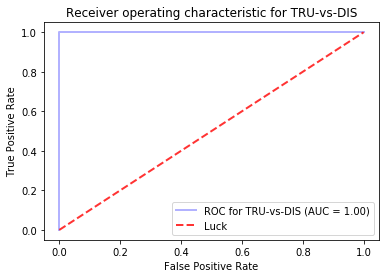

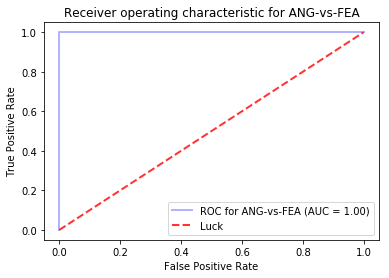

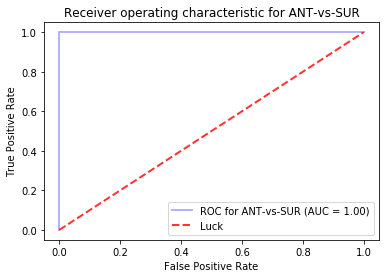

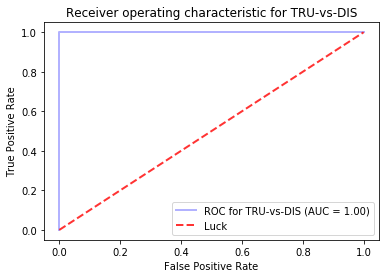

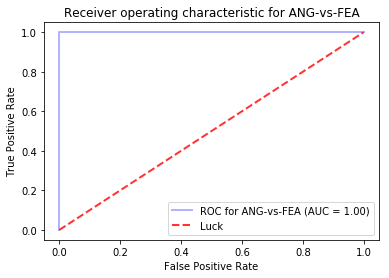

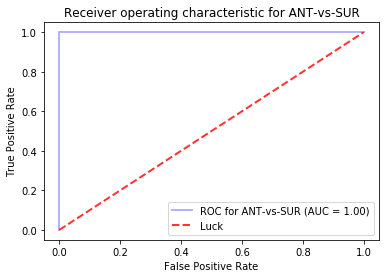

In [23]:
for emo_pair in emotions:
    print_roc_curve(results, emo_pair, "emo-vs-emo", "free-domain", "tk-1")
    
for emo_pair in emotions:
    print_roc_curve(results, emo_pair, "emo-vs-emo", "stock-domain", "tk-1")

In [9]:
all_emotions = ['JOY', 'SAD', 'TRU', 'DIS', 'ANG', 'FEA', 'SUR', 'ANT']

for emo in all_emotions:
    emo_pair_key = 'all-vs-%s' % emo   
    
    tk_list = ['tk-mos']
        
    for alg_name in tk_list:
        print("%s, free-domain" % alg_name)
        svm_tree_classifier(emo_pair_key, 'ALL', emo, "all-vs-emo", 'free-domain', alg_name, logs_path, dataset_path, True)
        print("%s, stock-domain" % alg_name)
        svm_tree_classifier(emo_pair_key, 'ALL', emo, "all-vs-emo", 'stock-domain', alg_name, logs_path, dataset_path, True)
        print("%s, stock-domain-full-agreement" % alg_name)
        svm_tree_classifier(emo_pair_key, 'ALL', emo, "all-vs-emo", 'stock-domain-full-agreement', alg_name, logs_path, dataset_path, True)

tk-mos, free-domain


KeyError: 'all-vs-JOY'

In [10]:
def print_exp_results(results, exp_name, score):
    from IPython.core.display import display, HTML
    
    results_html = "<table>\n"
    
    header1 = '<tr><th></th>\n'
    header2 = '<tr><td></td>\n'
    lines = {}
    for k in results[exp_name].keys():
        header1 += '<th colspan="%d">%s</th>\n' % (len(results[exp_name][k].keys()), k)
        for k2 in results[exp_name][k].keys():
            header2 += '<td>%s</td>\n' % k2
            
            for k3 in results[exp_name][k][k2].keys():
                if not k3 in lines.keys():
                    lines[k3] = '<td>%s</td>' % k3
                lines[k3] += '<td>%.3f</td>' % results[exp_name][k][k2][k3][score]
            
    results_html += header1 + "</tr>" + header2 + "</tr>"
    for k in lines.keys():
        results_html += "<tr>" + lines[k] + "</tr>\n"
        
    display(HTML(results_html))

In [11]:
print('Show accuracy')
print_exp_results(results, "emo-vs-emo", 'acc')
#print_exp_results(results, "emo-vs-emo-vs-neutral", 'acc')
#print_exp_results(results, "all-vs-emo", 'acc')

print('Show F1 Score')
print_exp_results(results, "emo-vs-emo", 'f1')
#print_exp_results(results, "emo-vs-emo-vs-neutral", 'f1')
#print_exp_results(results, "all-vs-emo", 'f1')



Show accuracy


Show F1 Score


In [44]:
with open('results_svm_tk.pkl', 'wb') as handle:
    pickle.dump(results, handle)
handle.close()